In [53]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### State

In [54]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]               # 사용자 입력     
    plan: Annotated[List[str], "Current plan"]          # 현재 계획
    past_steps: Annotated[List[Tuple], operator.add]    # 이전에 실행한 계획과 실행 결과
    response: Annotated[str, "Final response"]          # 답변

In [55]:
state1_PlanExecute = PlanExecute(
    input='겔럭시폰을 만든 회사는?',
    plan=[] ,
    past_steps=[],
    response=''
)

state1_PlanExecute

{'input': '겔럭시폰을 만든 회사는?', 'plan': [], 'past_steps': [], 'response': ''}

### 계획 모델

In [56]:
from pydantic import BaseModel, Field
from typing import List

class Plan(BaseModel):                                  # Plan 모델 정의
    """Sorted steps to execute the plan"""          

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]

In [57]:
# Different steps to follow, should be in sorted order
# 따라야 할 다양한 단계들로, 정렬된 순서로 있어야 합니다.

In [58]:
plan = Plan(
    steps=[
        "'겔럭시폰'이라는 이름을 확인한다", 
        "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", 
        "삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다."
    ]
)

plan

Plan(steps=["'겔럭시폰'이라는 이름을 확인한다", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.'])

### 사용자 답변 모델

In [59]:
from pydantic import BaseModel

class Response(BaseModel):
    """Response to user."""

    # 사용자 응답
    response: str

### Re-Plan 모델

In [60]:
from typing import Union
from pydantic import BaseModel, Field

class Act(BaseModel):
    """Action to perform."""

    # 수행할 작업: "Response", "Plan". 사용자에게 응답할 경우 Response 사용, 추가 도구 사용이 필요할 경우 Plan 사용
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [61]:
# Action to perform. If you want to respond to user, use Response.
# 수행할 작업. 사용자에게 응답하려면 Response를 사용하세요.

# If you need to further use tools to get the answer, use Plan.
# 답변을 얻기 위해 추가적으로 도구를 사용해야 한다면 Plan을 사용하세요.


In [62]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langgraph.prebuilt import create_react_agent

### 도구 정의 (웹 검색)

In [63]:
from langchain_teddynote.tools import TavilySearch

tools = [TavilySearch(max_results=1)]

### 계획 단계

In [64]:
# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
Answer in Korean.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

planner = planner_prompt | llm.with_structured_output(Plan)

In [65]:

# For the given objective, come up with a simple step by step plan.
# 주어진 목표를 위해 간단한 단계별 계획을 세우세요.

# This plan should involve individual tasks, that if executed correctly will yield the correct answer.
# 이 계획은 개별 작업을 포함해야 하며, 올바르게 실행하면 정확한 답을 도출할 수 있어야 합니다.

# Do not add any superfluous steps.
# 불필요한 단계를 추가하지 마세요.

# The result of the final step should be the final answer.
# 최종 단계의 결과는 최종 답이어야 합니다.

# Make sure that each step has all the information needed - do not skip steps.
# 각 단계가 필요한 모든 정보를 포함하도록 하세요 - 단계를 생략하지 마세요.


In [66]:
# Planner 실행
planner.invoke({"messages": [("user", "겔럭시폰을 만든 회사는?")]})

Plan(steps=["'겔럭시폰'이라는 이름을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.'])

### Agent (작업 실행 에이전트)

In [67]:
# 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

# ReAct 에이전트 생성
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

In [68]:
agent_executor.invoke(
    {"messages": [("user", "겔럭시폰을 만든 회사는?")]}
)

{'messages': [HumanMessage(content='겔럭시폰을 만든 회사는?', additional_kwargs={}, response_metadata={}, id='e5e49d16-f481-40ee-805b-a11a164742bd'),
  AIMessage(content='겔럭시폰을 만든 회사는 삼성전자입니다. 삼성전자는 한국에 본사를 두고 있는 글로벌 전자제품 제조업체로, 갤럭시 시리즈 스마트폰을 포함한 다양한 전자제품을 생산하고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 145, 'total_tokens': 199, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_de57b65c90', 'finish_reason': 'stop', 'logprobs': None}, id='run-4922eee3-1304-4f76-a6bf-4ef9c9d4431f-0', usage_metadata={'input_tokens': 145, 'output_tokens': 54, 'total_tokens': 199, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

### 계획 노드

In [69]:
# 사용자 입력을 기반으로 계획을 생성하고 리턴
def plan_step(state: PlanExecute):
    print('=================================================================================')
    print(f"🔄 [Node] 계획 노드 🔄")
    
    print(f"[1] 사용자 입력: {state['input']}")

    plan = planner.invoke({"messages": [("user", state["input"])]})
    
    print('[2] planner 체인 실행: ')
    print(plan.steps)

    print('=================================================================================')

    # 생성된 계획의 단계 리스트 리턴
    return {"plan": plan.steps}             

In [70]:
state1_PlanExecute = PlanExecute(
    input='겔럭시폰을 만든 회사는?',
    plan=[] ,
    past_steps=[],
    response=''
)

state1_PlanExecute

{'input': '겔럭시폰을 만든 회사는?', 'plan': [], 'past_steps': [], 'response': ''}

In [71]:
state2_PlanExecute = PlanExecute(
    input='대구 동성로떡볶이?',
    plan=[] ,
    past_steps=[],
    response=''
)

state2_PlanExecute

{'input': '대구 동성로떡볶이?', 'plan': [], 'past_steps': [], 'response': ''}

In [72]:
result1 = plan_step(state1_PlanExecute)     # 계획 노드 실행

🔄 [Node] 계획 노드 🔄
[1] 사용자 입력: 겔럭시폰을 만든 회사는?
[2] planner 체인 실행: 
["'겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.", "'겔럭시폰'은 삼성전자가 제조하는 스마트폰 브랜드임을 확인한다.", '따라서, 겔럭시폰을 만든 회사는 삼성전자이다.']


In [73]:
result2 = plan_step(state2_PlanExecute)     # 계획 노드 실행

🔄 [Node] 계획 노드 🔄
[1] 사용자 입력: 대구 동성로떡볶이?
[2] planner 체인 실행: 
['인터넷 브라우저를 엽니다.', "검색 엔진에 '대구 동성로 떡볶이'를 입력합니다.", '검색 결과에서 관련 정보를 찾습니다.', '리뷰나 블로그 글을 통해 동성로 떡볶이의 위치와 맛에 대한 정보를 확인합니다.', '필요한 경우 지도 서비스를 이용해 동성로 떡볶이의 정확한 위치를 확인합니다.']


In [74]:
state1_PlanExecute['plan'] = result1['plan']
state1_PlanExecute

{'input': '겔럭시폰을 만든 회사는?',
 'plan': ["'겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.",
  "'겔럭시폰'은 삼성전자가 제조하는 스마트폰 브랜드임을 확인한다.",
  '따라서, 겔럭시폰을 만든 회사는 삼성전자이다.'],
 'past_steps': [],
 'response': ''}

In [75]:
state2_PlanExecute['plan'] = result2['plan']
state2_PlanExecute

{'input': '대구 동성로떡볶이?',
 'plan': ['인터넷 브라우저를 엽니다.',
  "검색 엔진에 '대구 동성로 떡볶이'를 입력합니다.",
  '검색 결과에서 관련 정보를 찾습니다.',
  '리뷰나 블로그 글을 통해 동성로 떡볶이의 위치와 맛에 대한 정보를 확인합니다.',
  '필요한 경우 지도 서비스를 이용해 동성로 떡볶이의 정확한 위치를 확인합니다.'],
 'past_steps': [],
 'response': ''}

### Agent 노드

In [76]:
# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    print('=================================================================================')
    print(f"🔄 [Node] 에이전트 노드 execute_step() 🔄")
    
    plan = state["plan"]

    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = ''

    for i, step in enumerate(plan):
        plan_str = plan_str + f"{i+1}. {step}" + '\n'
    
    plan_str.rstrip('\n')

    # print(f'plan 문자열')
    # print(plan_str)
    
    task = plan[0]

    # print('실행할 task: ')
    # print(task)

    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    
    print('실행할 task: ')
    print(task_formatted)

    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})

    print('\nagent_executor 실행: ')
    print([(task, agent_response["messages"][-1].content)])
    print('=================================================================================')



    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

In [77]:
result2 = execute_step(state1_PlanExecute)

🔄 [Node] 에이전트 노드 execute_step() 🔄
실행할 task: 
For the following plan:
1. '겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.
2. '겔럭시폰'은 삼성전자가 제조하는 스마트폰 브랜드임을 확인한다.
3. 따라서, 겔럭시폰을 만든 회사는 삼성전자이다.


You are tasked with executing [step 1. '겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.].

agent_executor 실행: 
[("'겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.", "'겔럭시폰'이라는 이름을 가진 제품은 삼성전자에서 제조하는 것으로 확인되었습니다. 삼성 갤럭시는 삼성전자의 모바일 제품 브랜드입니다.")]


In [78]:
result2_2 = execute_step(state2_PlanExecute)

🔄 [Node] 에이전트 노드 execute_step() 🔄
실행할 task: 
For the following plan:
1. 인터넷 브라우저를 엽니다.
2. 검색 엔진에 '대구 동성로 떡볶이'를 입력합니다.
3. 검색 결과에서 관련 정보를 찾습니다.
4. 리뷰나 블로그 글을 통해 동성로 떡볶이의 위치와 맛에 대한 정보를 확인합니다.
5. 필요한 경우 지도 서비스를 이용해 동성로 떡볶이의 정확한 위치를 확인합니다.


You are tasked with executing [step 1. 인터넷 브라우저를 엽니다.].

agent_executor 실행: 
[('인터넷 브라우저를 엽니다.', "죄송하지만, 저는 인터넷 브라우저를 직접 열 수 없습니다. 대신, 제가 검색을 도와드릴 수 있습니다. '대구 동성로 떡볶이'에 대한 정보를 검색해드릴까요?")]


In [79]:
state1_PlanExecute['past_steps'] = result2['past_steps']
state1_PlanExecute

{'input': '겔럭시폰을 만든 회사는?',
 'plan': ["'겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.",
  "'겔럭시폰'은 삼성전자가 제조하는 스마트폰 브랜드임을 확인한다.",
  '따라서, 겔럭시폰을 만든 회사는 삼성전자이다.'],
 'past_steps': [("'겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.",
   "'겔럭시폰'이라는 이름을 가진 제품은 삼성전자에서 제조하는 것으로 확인되었습니다. 삼성 갤럭시는 삼성전자의 모바일 제품 브랜드입니다.")],
 'response': ''}

In [80]:
state2_PlanExecute['past_steps'] = result2_2['past_steps']
state2_PlanExecute

{'input': '대구 동성로떡볶이?',
 'plan': ['인터넷 브라우저를 엽니다.',
  "검색 엔진에 '대구 동성로 떡볶이'를 입력합니다.",
  '검색 결과에서 관련 정보를 찾습니다.',
  '리뷰나 블로그 글을 통해 동성로 떡볶이의 위치와 맛에 대한 정보를 확인합니다.',
  '필요한 경우 지도 서비스를 이용해 동성로 떡볶이의 정확한 위치를 확인합니다.'],
 'past_steps': [('인터넷 브라우저를 엽니다.',
   "죄송하지만, 저는 인터넷 브라우저를 직접 열 수 없습니다. 대신, 제가 검색을 도와드릴 수 있습니다. '대구 동성로 떡볶이'에 대한 정보를 검색해드릴까요?")],
 'response': ''}

### re-plan 단계

In [81]:
# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Answer in Korean."""
)


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

# Replanner 생성
replanner = replanner_prompt | llm.with_structured_output(Act)

In [82]:
replanner_res = replanner.invoke(state1_PlanExecute)

In [83]:
replanner_res

Act(action=Response(response='현재까지 수행된 단계에 따라, 추가적인 단계는 필요하지 않습니다. \n\n최종 답변: 겔럭시폰을 만든 회사는 삼성전자입니다.'))

### Re-Plan (재계획) 노드

In [84]:
# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    print('=================================================================================')
    print(f"🔄 [Node] Re-Plan (재계획) 노드 replan_step() 🔄")

    output = replanner.invoke(state)

    print(f'replanner.invoke() 실행: ')
    print(output)

    if isinstance(output.action, Response):                 # 응답이 사용자에게 리턴한 경우
        print('[리턴] Response: ')
        print( output.action.response)
        print('=================================================================================')

        return {"response": output.action.response}
    else:
        next_plan = output.action.steps
        
        if len(next_plan) == 0:
            print('실행할 단계가 없는 경우: No more steps needed')            
            print('=================================================================================')

            return {"response": "No more steps needed."}
        else:
            print('실행할 단계가 남은 경우: ')
            print(next_plan)
            print('=================================================================================')

            return {"plan": next_plan}

In [85]:
state1_PlanExecute_replain_res = replan_step(state1_PlanExecute)

🔄 [Node] Re-Plan (재계획) 노드 replan_step() 🔄
replanner.invoke() 실행: 
action=Response(response="현재까지의 진행 상황에 따르면, 이미 '겔럭시폰'이 삼성전자에서 제조된다는 사실을 확인하였습니다. 따라서 추가적인 단계는 필요하지 않으며, 최종 답변을 사용자에게 제공할 수 있습니다.\n\n최종 답변: 겔럭시폰을 만든 회사는 삼성전자입니다.")
[리턴] Response: 
현재까지의 진행 상황에 따르면, 이미 '겔럭시폰'이 삼성전자에서 제조된다는 사실을 확인하였습니다. 따라서 추가적인 단계는 필요하지 않으며, 최종 답변을 사용자에게 제공할 수 있습니다.

최종 답변: 겔럭시폰을 만든 회사는 삼성전자입니다.


In [86]:
state1_PlanExecute_replain_res

{'response': "현재까지의 진행 상황에 따르면, 이미 '겔럭시폰'이 삼성전자에서 제조된다는 사실을 확인하였습니다. 따라서 추가적인 단계는 필요하지 않으며, 최종 답변을 사용자에게 제공할 수 있습니다.\n\n최종 답변: 겔럭시폰을 만든 회사는 삼성전자입니다."}

In [87]:
state1_PlanExecute['response'] = state1_PlanExecute_replain_res['response']

In [88]:
state1_PlanExecute

{'input': '겔럭시폰을 만든 회사는?',
 'plan': ["'겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.",
  "'겔럭시폰'은 삼성전자가 제조하는 스마트폰 브랜드임을 확인한다.",
  '따라서, 겔럭시폰을 만든 회사는 삼성전자이다.'],
 'past_steps': [("'겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.",
   "'겔럭시폰'이라는 이름을 가진 제품은 삼성전자에서 제조하는 것으로 확인되었습니다. 삼성 갤럭시는 삼성전자의 모바일 제품 브랜드입니다.")],
 'response': "현재까지의 진행 상황에 따르면, 이미 '겔럭시폰'이 삼성전자에서 제조된다는 사실을 확인하였습니다. 따라서 추가적인 단계는 필요하지 않으며, 최종 답변을 사용자에게 제공할 수 있습니다.\n\n최종 답변: 겔럭시폰을 만든 회사는 삼성전자입니다."}

### Agent 실행을 계속할지 결정하는 함수

In [89]:
def should_end(state: PlanExecute):
    print('=================================================================================')
    print(f"🔄 [함수] 에이전트 실행을 계속할지 결정 should_end() 🔄")

    if "response" in state and state["response"]:
        print('결과: final_report')
        print('=================================================================================')
        return "final_report"
    else:
        print('결과: execute')
        print('=================================================================================')
        return "execute"

In [90]:
should_end(state1_PlanExecute)

🔄 [함수] 에이전트 실행을 계속할지 결정 should_end() 🔄
결과: final_report


'final_report'

In [98]:
final_report_prompt = ChatPromptTemplate.from_template(
    """You are given the objective and the previously done steps. Your task is to generate a final report in markdown format.
Final report should be written in professional tone.

Your objective was this:

{input}

Your previously done steps(question and answer pairs):

{past_steps}

Generate a final report in markdown format. Write your response in Korean."""
)


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

output_parer = StrOutputParser()

final_report = final_report_prompt | llm | output_parer 

In [102]:
def generate_final_report(state: PlanExecute):
    print('=================================================================================')
    print(f"🔄 [함수] 리포트 생성 노드 generate_final_report() 🔄")

    past_steps  = ''


    for past_step in state["past_steps"]:
        question = past_step[0]                 # 첫 번째 요소는 질문
        answer = past_step[1]                   # 두 번째 요소는 답변
        
        # 현재 질문과 답변을 포맷팅하여 `past_steps`에 추가
        formatted_step = f"Question: {question}\n\nAnswer: {answer}\n\n####"

        past_steps = past_steps + formatted_step + "\n\n"  # 각 단계 사이에 두 줄 띄우기


    print('past_steps:')
    print(past_steps)

    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})

    print('final_report 실행: ')
    print(response)
    print('=================================================================================')


    return {"response": response}

In [103]:
state1_PlanExecute_final_prompt = generate_final_report(state1_PlanExecute)

🔄 [함수] 리포트 생성 노드 generate_final_report() 🔄
past_steps:
Question: '겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.

Answer: '겔럭시폰'이라는 이름을 가진 제품은 삼성전자에서 제조하는 것으로 확인되었습니다. 삼성 갤럭시는 삼성전자의 모바일 제품 브랜드입니다.

####


final_report 실행: 
# 최종 보고서

## 개요

본 보고서는 "겔럭시폰을 만든 회사는?"이라는 질문에 대한 조사 결과를 제공합니다. 이 보고서는 겔럭시폰의 제조사를 확인하기 위한 일련의 조사 단계를 통해 얻어진 정보를 바탕으로 작성되었습니다.

## 조사 결과

### 질문

- **질문:** '겔럭시폰'이라는 이름을 가진 제품이 어떤 회사에서 제조하는지 확인한다.

### 답변

- **답변:** '겔럭시폰'이라는 이름을 가진 제품은 삼성전자에서 제조하는 것으로 확인되었습니다. 삼성 갤럭시는 삼성전자의 모바일 제품 브랜드입니다.

## 결론

조사 결과, 겔럭시폰은 삼성전자에서 제조하는 제품임이 명확히 확인되었습니다. 삼성 갤럭시는 삼성전자의 대표적인 모바일 제품 브랜드로, 전 세계적으로 널리 알려져 있습니다. 본 보고서는 겔럭시폰의 제조사를 명확히 밝히는 데 성공하였습니다.

## 참고 문헌

- 삼성전자 공식 웹사이트
- 관련 산업 보고서 및 뉴스 기사

본 보고서는 겔럭시폰의 제조사에 대한 명확한 정보를 제공하며, 관련된 추가적인 질문이나 논의가 필요할 경우, 추가 조사를 통해 더 깊이 있는 정보를 제공할 수 있습니다.


In [104]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)                         # 계획 노드
workflow.add_node("execute", execute_step)                      # 에이전트 노드
workflow.add_node("replan", replan_step)                        # 재계획 노드
workflow.add_node("final_report", generate_final_report)        # 리포트 생성 노드

# 엣지 정의
workflow.add_edge(START, "planner")                             # START                          에서   계획(planner)     노드
workflow.add_edge("planner", "execute")                         # 계획(planner) 노드             에서   에이전트(execute) 노드 
workflow.add_edge("execute", "replan")                          # 에이전트(execute) 노드         에서   재계획(replan)    노드
workflow.add_edge("final_report", END)                          # 리포트 생성(final_report) 노드 에서   END

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

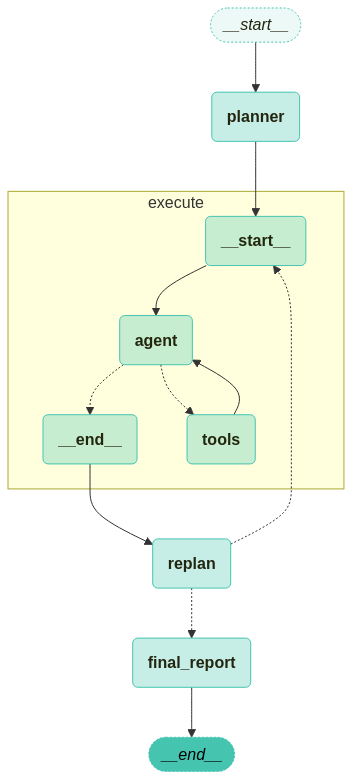

In [105]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

In [106]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": "겔럭시폰을 만든 회사는?"
}

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)

🔄 [Node] 계획 노드 🔄
[1] 사용자 입력: 겔럭시폰을 만든 회사는?
[2] planner 체인 실행: 
["'겔럭시폰'이라는 제품명을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", "삼성전자가 '겔럭시폰'을 만든 회사임을 결론짓는다."]
[node_name]: planner
[node_chunk]:
 {'plan': ["'겔럭시폰'이라는 제품명을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", "삼성전자가 '겔럭시폰'을 만든 회사임을 결론짓는다."]}
🔄 [Node] 에이전트 노드 execute_step() 🔄
실행할 task: 
For the following plan:
1. '겔럭시폰'이라는 제품명을 확인한다.
2. '겔럭시폰'이 삼성전자의 제품임을 확인한다.
3. 삼성전자가 '겔럭시폰'을 만든 회사임을 결론짓는다.


You are tasked with executing [step 1. '겔럭시폰'이라는 제품명을 확인한다.].

agent_executor 실행: 
[("'겔럭시폰'이라는 제품명을 확인한다.", "'겔럭시폰'은 삼성전자의 제품명으로 확인되었습니다. 삼성 갤럭시 핸드폰은 다양한 모델명과 함께 시리얼 넘버, 일련번호, IMEI 등을 확인할 수 있는 방법이 제공되고 있습니다.")]
[node_name]: execute
[node_chunk]:
 {'past_steps': [("'겔럭시폰'이라는 제품명을 확인한다.", "'겔럭시폰'은 삼성전자의 제품명으로 확인되었습니다. 삼성 갤럭시 핸드폰은 다양한 모델명과 함께 시리얼 넘버, 일련번호, IMEI 등을 확인할 수 있는 방법이 제공되고 있습니다.")]}
🔄 [Node] Re-Plan (재계획) 노드 replan_step() 🔄
replanner.invoke() 실행: 
action=Response(response="삼성전자가 '겔럭시폰'을 만든 회사임을 결론짓는다.")
[리턴] Response: 
삼성전자가 '겔럭시폰'을 만든 회사임을 결론짓는다.
🔄 [함수

In [97]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": "겔럭시폰을 만든 회사는?"
}

for event in app.stream(inputs, config=config, stream_mode='updates'):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)

🔄 [Node] 계획 노드 🔄
[1] 사용자 입력: 겔럭시폰을 만든 회사는?
[2] planner 체인 실행: 
["'겔럭시폰'이라는 이름의 제품을 만든 회사의 이름을 찾는다.", "'겔럭시폰'은 삼성전자가 만든 제품임을 확인한다.", '따라서, 겔럭시폰을 만든 회사는 삼성전자이다.']
[node_name]: planner
[node_chunk]:
 {'plan': ["'겔럭시폰'이라는 이름의 제품을 만든 회사의 이름을 찾는다.", "'겔럭시폰'은 삼성전자가 만든 제품임을 확인한다.", '따라서, 겔럭시폰을 만든 회사는 삼성전자이다.']}
🔄 [Node] 에이전트 노드 execute_step() 🔄
실행할 task: 
For the following plan:
1. '겔럭시폰'이라는 이름의 제품을 만든 회사의 이름을 찾는다.
2. '겔럭시폰'은 삼성전자가 만든 제품임을 확인한다.
3. 따라서, 겔럭시폰을 만든 회사는 삼성전자이다.


You are tasked with executing [step 1. '겔럭시폰'이라는 이름의 제품을 만든 회사의 이름을 찾는다.].

agent_executor 실행: 
[("'겔럭시폰'이라는 이름의 제품을 만든 회사의 이름을 찾는다.", "'겔럭시폰'이라는 이름의 제품을 만든 회사는 삼성전자입니다.")]
[node_name]: execute
[node_chunk]:
 {'past_steps': [("'겔럭시폰'이라는 이름의 제품을 만든 회사의 이름을 찾는다.", "'겔럭시폰'이라는 이름의 제품을 만든 회사는 삼성전자입니다.")]}
🔄 [Node] Re-Plan (재계획) 노드 replan_step() 🔄
replanner.invoke() 실행: 
action=Response(response='겔럭시폰을 만든 회사는 삼성전자입니다. 더 이상의 단계는 필요하지 않습니다.')
[리턴] Response: 
겔럭시폰을 만든 회사는 삼성전자입니다. 더 이상의 단계는 필요하지 않습니다.
🔄 [함수] 에이전트 실행을 계속할지 결정 shoul